In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T
import torch.optim as optim
import torchmetrics

# Для чтения изображений с диска
from torchvision import io # input/output
import torchutils as tu
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [2]:
trnsfrms = T.Compose(
    [
        T.Resize((224, 224)),
        #T.RandomHorizontalFlip(),
        #T.RandomRotation(15),
        #T.RandomPerspective(),
        T.ToTensor() # автоматически интервал пикселей будет 0-1
    ]
)

In [3]:
train_dataset = torchvision.datasets.ImageFolder(
    './data/archive_blood/TRAIN',
    transform=trnsfrms
)
valid_dataset = torchvision.datasets.ImageFolder(
    './data/archive_blood//TEST',
    transform=trnsfrms
)

In [4]:
idx2class= {j: i for i, j in train_dataset.class_to_idx.items()}

In [5]:
idx2class

{0: 'EOSINOPHIL', 1: 'LYMPHOCYTE', 2: 'MONOCYTE', 3: 'NEUTROPHIL'}

In [6]:
df_labels = pd.DataFrame.from_dict(idx2class, orient='index')
df_labels

,0
0,EOSINOPHIL
1,LYMPHOCYTE
2,MONOCYTE
3,NEUTROPHIL


In [7]:
df_labels.to_csv('./models/model_blood/data_labels.csv', index=False, encoding='utf-8')

In [8]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=256, shuffle=True)

In [9]:
if torch.cuda.is_available():
    print("CUDA доступна!")
    device = torch.device("cuda")
else:
    print("CUDA недоступна. Вычисления будут выполняться на CPU.")
    device = torch.device("cpu")

CUDA доступна!


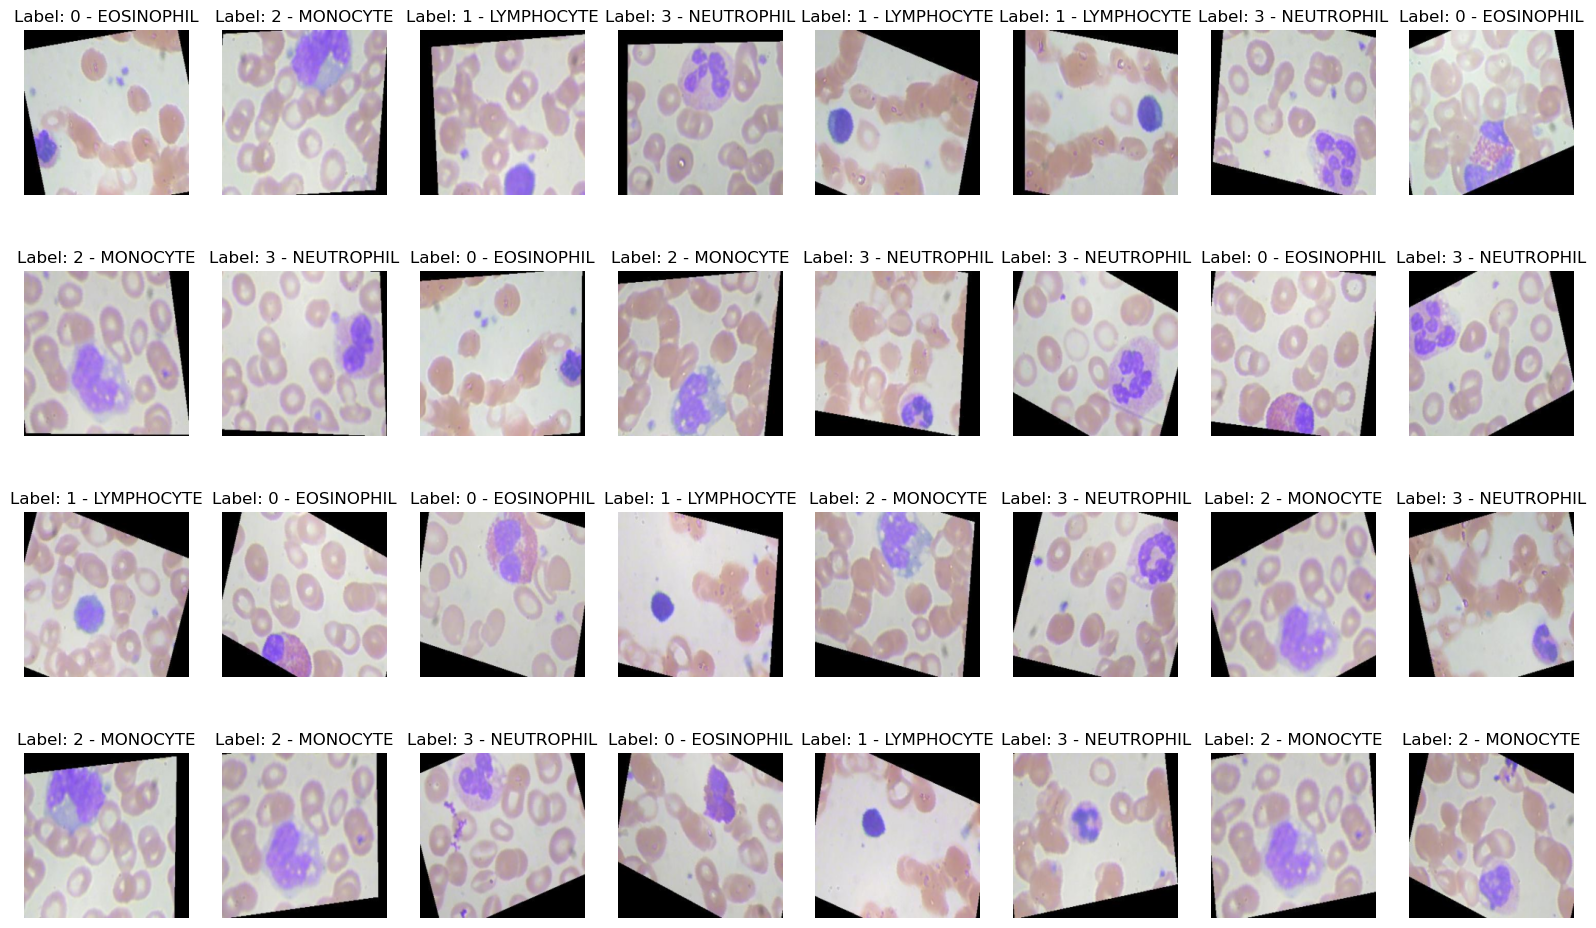

In [10]:
fig, ax = plt.subplots(4, 8, figsize=(20, 12))
ax = ax.flatten()
test_batch = next(iter(valid_loader))
test_samples, test_targets = test_batch

for i, plot in enumerate(ax):
    label_index = test_targets[i].item()
    plot.set_title(f'Label: {label_index} - {valid_loader.dataset.classes[label_index]}')

    # Проверяем количество каналов
    if test_samples[i].shape[0] == 3:  # Если 3 канала (RGB)
        img = test_samples[i].permute(1, 2, 0)  # Транспонируем в (высота, ширина, каналы)
        #img = (img + 1) / 2  # Переводим в диапазон [0, 1]
        #img = img * 255      # Переводим в диапазон [0, 255]
        #img = img.int()   
    elif test_samples[i].shape[0] == 1:  # Если 1 канал (оттенки серого)
        img = test_samples[i][0, :, :]  # Оставляем как есть
    else:
        raise ValueError("Неизвестное количество каналов")

    plot.imshow(img.cpu())  # Используем imshow() для цветных изображений
    plot.axis('off')

plt.show()

In [11]:
def fit(
        model: torch.nn.Module,
        n_epochs: int,
        optimizer: torch.optim.Optimizer,
        criterion,
        train_loader: DataLoader,
        valid_loader: DataLoader,
        ) -> tuple[list, ...]:

    accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=4).to(device)  # Инициализируем torchmetrics.Accuracy

    train_losses = []
    valid_losses = []
    train_metrics = []
    valid_metrics = []
    time_metrics = []

    for epoch in range(n_epochs):
        start = datetime.datetime.now()
        
        model.train()

        train_loss_epoch = []
        train_metric_epoch = []

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)  # Используем переданный criterion

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = accuracy(outputs, labels)  # Используем torchmetrics.Accuracy
            train_loss_epoch.append(loss.item())
            train_metric_epoch.append(acc.item())

        model.eval()

        valid_loss_epoch = []
        valid_metric_epoch = []

        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(images)  # Получаем выходы модели

            loss = criterion(outputs, labels)
            acc = accuracy(outputs, labels)

            valid_loss_epoch.append(loss.item())
            valid_metric_epoch.append(acc.item())

        epoch_train_loss = np.mean(train_loss_epoch)
        epoch_train_metric = np.mean(train_metric_epoch)

        epoch_valid_loss = np.mean(valid_loss_epoch)
        epoch_valid_metric = np.mean(valid_metric_epoch)

        time = (datetime.datetime.now() - start).total_seconds()
        time_metrics.append(round(time))
        train_losses.append(epoch_train_loss)
        valid_losses.append(epoch_valid_loss)
        train_metrics.append(epoch_train_metric)
        valid_metrics.append(epoch_valid_metric)
        

        print(f"Epoch {epoch+1}/{n_epochs}: Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_metric:.4f}, Valid Loss: {epoch_valid_loss:.4f}, Valid Accuracy: {epoch_valid_metric:.4f}")

        
    return train_losses, valid_losses, train_metrics, valid_metrics, time_metrics

In [12]:
#from torchvision.models import resnet18, ResNet18_Weights

#model_lrs = resnet18(weights="DEFAULT")

In [13]:
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights

model_eff = efficientnet_b3(weights=EfficientNet_B3_Weights.DEFAULT)

In [14]:
tu.get_model_summary(model_eff.to(device), test_samples[1].unsqueeze(0).to(device))

Layer                                                     Kernel               Output          Params          FLOPs
0_features.0.Conv2d_0                                    [3, 40, 3, 3]    [1, 40, 112, 112]       1,080   13,547,520
1_features.0.BatchNorm2d_1                                        [40]    [1, 40, 112, 112]          80    2,007,040
2_features.0.SiLU_2                                                  -    [1, 40, 112, 112]           0            0
3_features.1.0.block.0.Conv2d_0                          [1, 40, 3, 3]    [1, 40, 112, 112]         360    4,515,840
4_features.1.0.block.0.BatchNorm2d_1                              [40]    [1, 40, 112, 112]          80    2,007,040
5_features.1.0.block.0.SiLU_2                                        -    [1, 40, 112, 112]           0            0
6_features.1.0.block.1.AdaptiveAvgPool2d_avgpool                     -        [1, 40, 1, 1]           0      501,800
7_features.1.0.block.1.Conv2d_fc1                       [40, 10,

In [15]:
for param in model_eff.parameters():
    param.requires_grad = False

In [16]:
#for i, param in enumerate(model_eff.parameters()):
    #print(i, param.requires_grad)

In [17]:
#for name, param in model_eff.named_parameters():
    #if param.requires_grad:
    #print(f"Тренируемый параметр: {name}")

In [18]:
model_eff.classifier[1]

Linear(in_features=1536, out_features=1000, bias=True)

In [19]:
display(model_eff.classifier[1])
model_eff.classifier[1] = nn.Linear(1536, 4)
display(model_eff.classifier[1])

Linear(in_features=1536, out_features=1000, bias=True)

Linear(in_features=1536, out_features=4, bias=True)

In [20]:
model_eff.features[7][0].block[3][1]

BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [21]:
model_eff.features[7][0].block[3][0].weight.requires_grad = True

model_eff.features[7][0].block[3][1].weight.requires_grad = True
model_eff.features[7][0].block[3][1].bias.requires_grad = True

model_eff.features[8][0].weight.requires_grad = True

model_eff.features[8][1].weight.requires_grad = True
model_eff.features[8][1].bias.requires_grad = True

model_eff.classifier[1].weight.requires_grad = True
model_eff.classifier[1].bias.requires_grad = True

In [22]:
for param in model_eff.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [23]:
criterion_eff = nn.CrossEntropyLoss()
optimizer_eff = optim.SGD(model_eff.parameters(), lr=0.001)

In [24]:
model_eff.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [25]:
history = None

In [26]:
torch.cuda.empty_cache()

In [ ]:
%%time
start = datetime.datetime.now()
print('Время старта: ' + str(start))

#model_lrs.to(device)

model_data = fit(n_epochs=20, model=model_eff, optimizer=optimizer_eff, train_loader=train_loader, valid_loader=valid_loader, criterion=criterion_eff)

finish = datetime.datetime.now()
print('Время окончания: ' + str(finish))

# вычитаем время старта из времени окончания
print('Время : ' + str(finish - start))

Время старта: 2025-02-07 16:23:12.822745


In [ ]:
torch.save(model_eff, './models/model_blood/model_eff3_blood.pth')

In [ ]:
#torch.save(model_lrs.state_dict(), './models/model_sport/model_weights.pth')

In [ ]:
train_losses, valid_losses, train_metric, valid_metric, time = model_data

In [ ]:
data_metrics = np.array([
    train_losses, valid_losses, train_metric, valid_metric, time
])

df = pd.DataFrame(data_metrics.T, columns=['train_losses', 'valid_losses', 'train_metric', 'valid_metric', 'time'])
df

In [ ]:
df.to_csv('./models/model_blood/data_blood_eff3.csv', index=False, encoding='utf-8')

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

ax[0].plot(train_losses, label='Train loss')
ax[0].plot(valid_losses, label='Valid Loss')
ax[0].legend()
ax[0].set_title('Loss')
ax[0].set_ylim((0, max(train_losses+valid_losses)+.1))

ax[1].plot(train_metric, label='Train accuracy')
ax[1].plot(valid_metric, label='Valid accuracy')
ax[1].legend()
ax[1].set_title('Accuracy')
ax[1].set_ylim((0, max(train_metric+valid_metric)+.1))

In [ ]:
fig, ax = plt.subplots(4, 8, figsize=(20, 12))
ax = ax.flatten() # переводим в одномерный массив
test_batch = next(iter(valid_loader))
test_samples, test_targets = test_batch
test_samples = test_samples.to(device)
for i, plot in enumerate(ax):
    label_index = test_targets[i].item()  # Получаем индекс метки из тестового набора
    y_pred = torch.argmax(model_lrs(test_samples[i].unsqueeze(0)))
    y_pred = y_pred.cpu().detach().numpy()
    color = 'r' if y_pred != label_index else 'g'
    plot.set_title(f'  Label: {label_index} - {train_loader.dataset.classes[label_index]}\n'
                   f'Predict: {y_pred} - {train_loader.dataset.classes[y_pred]}', color=color)
    if test_samples[i].shape[0] == 3:  # Если 3 канала (RGB)
        img = test_samples[i].permute(1, 2, 0)  # Транспонируем в (высота, ширина, каналы)
        #img = (img + 1) / 2  # Переводим в диапазон [0, 1]
        #img = img * 255      # Переводим в диапазон [0, 255]
        #img = img.int()   
    plot.imshow(img.cpu())#plot.matshow(test_samples[i][0, :, :].cpu().detach().numpy(), cmap='gray')
    plot.axis('off')